# Import packages

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time

# Classifiers
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import plot_confusion_matrix

%matplotlib inline

import sys
sys.path.append("..")
from CustomTransformer import CustomTransformer

In [77]:
import os 
os.chdir("../")
bucket = 'aws-project-politomaster-sagemaker-data' 

# Import pre-processed datasets

In [78]:
prep_train_path = os.path.join('s3://', bucket, 'preprocess/prep_train.csv')
prep_train = pd.read_csv(prep_train_path)
print("Prep_train dataset has: {} rows and {} columns".format(prep_train.shape[0], prep_train.shape[1]))
prep_train.head()

Prep_train dataset has: 43170 rows and 10 columns


,carat_class,cut,color,clarity,depth,table,price,x,y,z
0,0,4,5,1,61.746807,54.834605,651.357414,5.350743,4.352193,2.667488
1,0,3,5,2,60.811398,60.300733,651.357414,5.350743,4.352193,2.667488
2,0,1,5,4,59.799569,60.300733,651.357414,5.350743,4.352193,2.667488
3,0,3,1,3,62.110048,57.770527,651.357414,5.350743,4.352193,2.667488
4,0,1,0,1,63.367713,58.202601,651.357414,5.350743,4.352193,2.899670


In [79]:
prep_test_path = os.path.join('s3://', bucket, 'preprocess/prep_test.csv')
prep_test = pd.read_csv(prep_test_path)
print("Prep_test dataset has: {} rows and {} columns".format(prep_test.shape[0], prep_test.shape[1]))
prep_train.head()

Prep_test dataset has: 10770 rows and 10 columns


,carat_class,cut,color,clarity,depth,table,price,x,y,z
0,0,4,5,1,61.746807,54.834605,651.357414,5.350743,4.352193,2.667488
1,0,3,5,2,60.811398,60.300733,651.357414,5.350743,4.352193,2.667488
2,0,1,5,4,59.799569,60.300733,651.357414,5.350743,4.352193,2.667488
3,0,3,1,3,62.110048,57.770527,651.357414,5.350743,4.352193,2.667488
4,0,1,0,1,63.367713,58.202601,651.357414,5.350743,4.352193,2.899670


# Analyze feature correlation

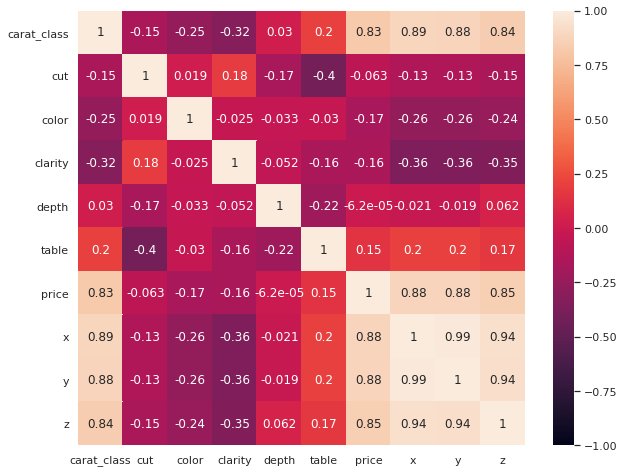

In [80]:
sns.set(rc={'figure.figsize':(10,8)})
fig, ax = plt.subplots(1, 1)
sns.heatmap(prep_train.corr(), vmin = -1, vmax= 1 , annot = True)
#plt.savefig("images/trainingCorr.png")
plt.show()

# Apply custom trasformation to add features

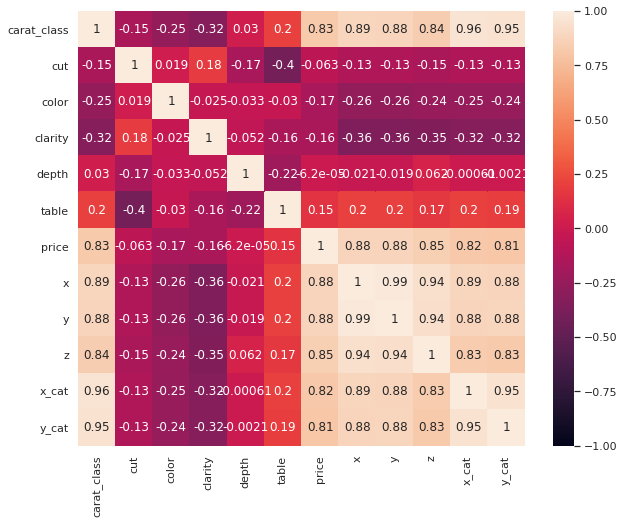

In [81]:
custom_transf = CustomTransformer()
new_train = custom_transf.transform(prep_train)

sns.set(rc={'figure.figsize':(10,8)})
fig, ax = plt.subplots(1, 1)
sns.heatmap(new_train.corr(), vmin = -1, vmax= 1 , annot = True)
#plt.savefig("images/trainingCorr.png")
plt.show()

# Split the training set into train and validation

In [82]:
seed = 0

target = prep_train['carat_class']
data = prep_train.drop(labels = ['carat_class'],axis = 1)
sample_train, sample_val, label_train, label_val = \
    train_test_split(data, target, test_size=0.3, random_state=seed)

# Test a baseline algorithm (SVC) with **standard scaler**

Time:  69.26132130622864
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7602
           1       0.98      0.99      0.99      4785
           2       0.97      0.94      0.95       564

    accuracy                           0.99     12951
   macro avg       0.98      0.97      0.98     12951
weighted avg       0.99      0.99      0.99     12951



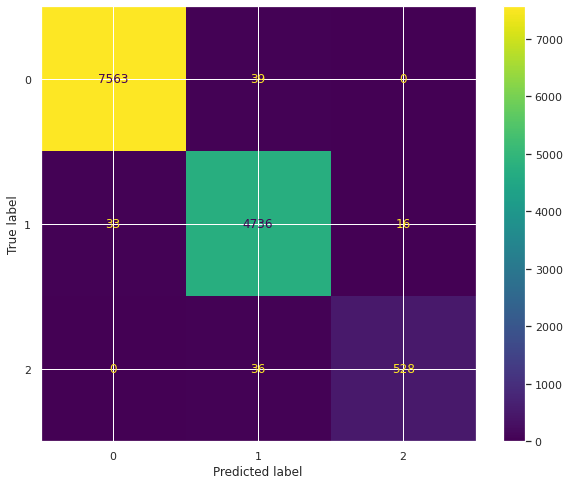

In [83]:
custom_transf = CustomTransformer()
std_scale = StandardScaler()
clf = SVC(gamma='auto',kernel='rbf', C = 1.0, random_state = seed)

t0 = time.time()
model = make_pipeline(custom_transf,std_scale,clf)
model.fit(sample_train, label_train)
pred = model.predict(sample_val)
t1 = time.time()
print('Time: ', t1-t0)
print(classification_report(label_val,pred))

sns.set(rc={'figure.figsize':(10,8)})
plot_confusion_matrix(model, sample_val, label_val)  
plt.show()

# Apply PCA with different components 

In [71]:
results_df = pd.DataFrame(columns = ['N_components','Class','Precision','Recall','F_score', 'Accuracy', 'Time'])
results_df.head()

,N_components,Class,Precision,Recall,F_score,Accuracy,Time


In [72]:
n_feature = len(sample_train.columns)
for feature_dim in range(1,n_feature+3):

    """
    Perform PCA in order to reduce the dataset dimensionality.
    """
    pca = PCA(n_components=feature_dim)

    t0 = time.time()
    model = make_pipeline(custom_transf,std_scale,pca,clf)
    model.fit(sample_train, label_train)
    pred = model.predict(sample_val)
    t1 = time.time()
    
    acc = accuracy_score(label_val,pred)
    print('PCA components: ',feature_dim)
    print('Time: ', t1-t0)
    
    scores = precision_recall_fscore_support(label_val,pred)
    for i in range(3):
        results_df = results_df.append({'N components': feature_dim, 
                                        'Class': i,
                                        'Precision': scores[0][i],
                                        'Recall': scores[1][i], 
                                        'F score': scores[2][i],
                                        'Accuracy': acc,
                                        'Time': t1-t0}, ignore_index=True)
    
    print(classification_report(label_val,pred))
    print('\n')

PCA components:  1
Time:  107.9092755317688
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7602
           1       0.97      0.99      0.98      4785
           2       0.97      0.90      0.93       564

    accuracy                           0.99     12951
   macro avg       0.98      0.96      0.97     12951
weighted avg       0.99      0.99      0.99     12951



PCA components:  2
Time:  38.34360933303833
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7602
           1       0.97      0.99      0.98      4785
           2       0.97      0.89      0.93       564

    accuracy                           0.98     12951
   macro avg       0.98      0.95      0.97     12951
weighted avg       0.98      0.98      0.98     12951



PCA components:  3
Time:  14.547837495803833
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   

# Analyze the results


* **Accuracy** : Accuracy is the ratio of correctly predicted observation to the total observations. One may think that, if we have high accuracy then our model is best. Yes, accuracy is a great measure but only when you have symmetric datasets where values of false positive and false negatives are almost same. Therefore, you have to look at other parameters to evaluate the performance of your model. 
Accuracy = (TP+TN)/(TP+FP+FN+TN)
* **Precision** :  Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. High precision relates to the low false positive rate.
Precision = TP/(TP+FP) 
* **Recall** : Recall is the ratio of correctly predicted positive observations to the all observations in actual class.
Recall = TP/(TP+FN)
* **F score** : F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall. 
F1 Score = 2*(Recall * Precision) / (Recall + Precision)

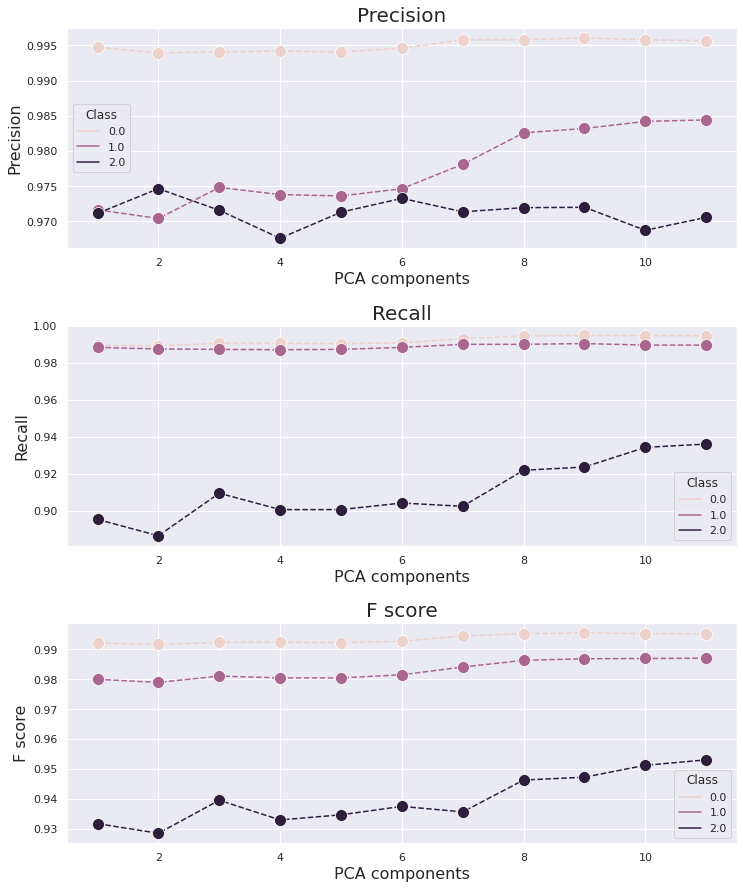

In [73]:
sns.set(rc={'figure.figsize':(12,15)})
sns.set_context("notebook", rc={"font.size":32,"axes.titlesize":20,"axes.labelsize":16})
fig, ax = plt.subplots(3,1)

for i,feature in zip(range(3),['Precision','Recall','F score']):
    sns.lineplot(x = results_df['N components'], y = results_df[feature], hue = results_df['Class'], 
                     marker='o',markersize=12,linestyle='dashed', ax = ax[i])
    ax[i].set(ylabel=feature, xlabel='PCA components', title=feature)

plt.subplots_adjust(hspace = 0.35)
#plt.savefig("images/SparkLearningCurve.png")  
plt.show()

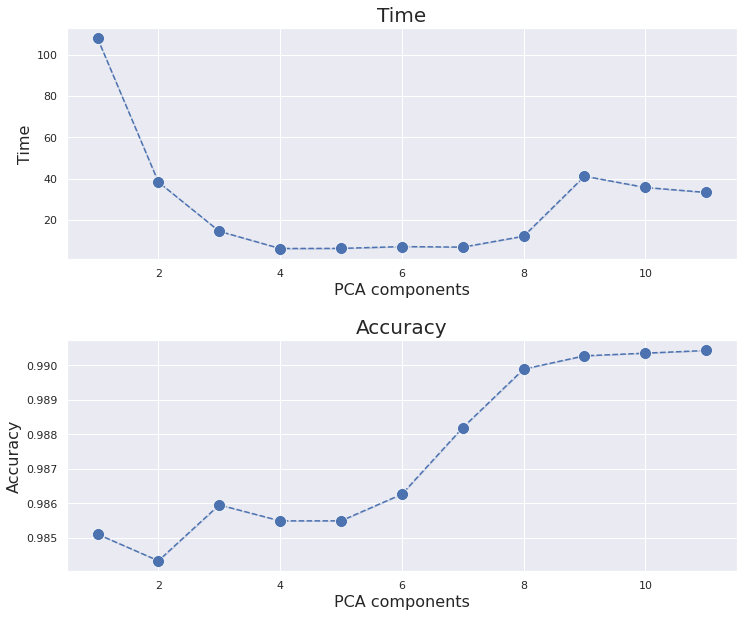

In [74]:
sns.set(rc={'figure.figsize':(12,10)})
sns.set_context("notebook", rc={"font.size":32,"axes.titlesize":20,"axes.labelsize":16})
fig, ax = plt.subplots(2,1)

for i,feature in zip(range(2),['Time','Accuracy']):
    sns.lineplot(x = results_df['N components'], y = results_df[feature],
                 marker='o',markersize=12,linestyle='dashed', ax = ax[i])
    ax[i].set(ylabel=feature, xlabel='PCA components', title=feature)
    
plt.subplots_adjust(hspace = 0.35)
#plt.savefig("images/SparkLearningCurve.png")  
plt.show()

# Test a baseline algorithm (SVC) with **standard scaler** and **PCA**

Time:  11.869551658630371
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7602
           1       0.98      0.99      0.99      4785
           2       0.97      0.92      0.95       564

    accuracy                           0.99     12951
   macro avg       0.98      0.97      0.98     12951
weighted avg       0.99      0.99      0.99     12951



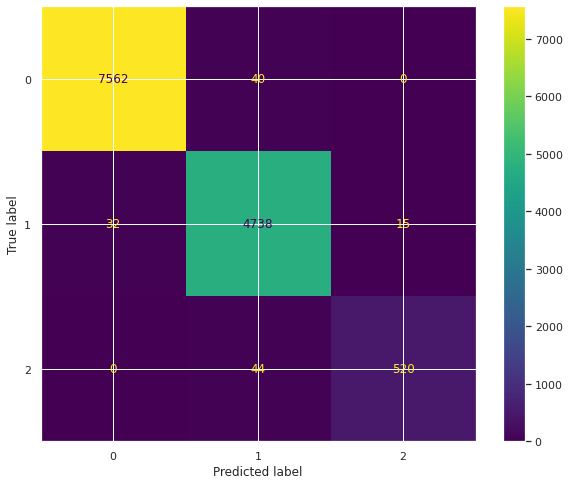

In [84]:
pca = PCA(n_components=8)

t0 = time.time()
model = make_pipeline(custom_transf,std_scale,pca,clf)
model.fit(sample_train, label_train)
pred = model.predict(sample_val)
t1 = time.time()
print('Time: ', t1-t0)
print(classification_report(label_val,pred))
sns.set(rc={'figure.figsize':(10,8)})
plot_confusion_matrix(model, sample_val, label_val)  
plt.show()